<a href="https://colab.research.google.com/github/Timoha-3000/1st_CUDA_Lab/blob/master/lab2_intelligent_systems_logistic_regression_Kriushin_PIN_12M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 2
*********
## Предсказание вероятности возникновения события по значениям множества признаков (логистическая регрессия)

На этом занятии компьютерного практикума вы изучите логистическую регрессию и примените метод логистической регрессии к обработке двух различных наборов данных, а именно, данных, характеризующих систему сигнализации об исправности двигателя автомобиля в процессе эксплуатации, и данных, описывающих автомат по отбраковке микрочипов на производстве. Прежде чем приступить, собственно, к программированию, настоятельно рекомендуется ознакомиться с материалом лекций, а также с дополнительными материалами, имеющими отношение к задаче логистической регрессии и классификации.

In [479]:
# импортируем все необходимые билиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns
sns.set(style='ticks')

## Инициализация

Перед началом работы у вас есть возможность выбрать формат файла, с которым вы будетет работать. Для работы с файлами формата .csv предлагается использовать библиотеку pandas. Но также вы можете загрузить данные из файла .txt с помощью функции np.loadtxt('.txt', delimiter=',' ), используя билиотеку numpy

In [480]:
df = pd.read_csv('engine.csv')

In [481]:
df.head()

,noise,rotation,class
0,30.286711,43.894998,0
1,35.847409,72.902198,0
2,60.182599,86.308552,1
3,79.032736,75.344376,1
4,45.083277,56.316372,0


In [482]:
df.describe()

,noise,rotation,class
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


In [483]:
# Формируем вектор признаков
m = len(df)
x = np.array(df['noise'])
temp = np.array(df['rotation'])
y = np.array(df['class'])

x = x.reshape((m, 1))
temp = temp.reshape((m, 1))
y = y.reshape((m, 1))
X = np.hstack((temp,x))
print(X[0:5])

[[43.89499752 30.28671077]
 [72.90219803 35.84740877]
 [86.3085521  60.18259939]
 [75.34437644 79.03273605]
 [56.31637178 45.08327748]]


In [484]:
# Добавляем к вектору признаков столбец единиц для theta_0
t = np.ones((m,1))
X = np.hstack((t,X))
print(X[0:5])

[[ 1.         43.89499752 30.28671077]
 [ 1.         72.90219803 35.84740877]
 [ 1.         86.3085521  60.18259939]
 [ 1.         75.34437644 79.03273605]
 [ 1.         56.31637178 45.08327748]]


## Задание 1. Отображение

До начала выполнения заданий желательно представить данные в графическом виде. В первой части ноутбука, как и в Лабораторной работе 1, посвященной линейной регрессии, для этого будет вызвана функция построения двухмерных графиков plotData. Вам необходимо завершить программу plotData так, чтобы её результатом служил график, подобный приведенному на Рис. 1, где оси соответствуют двум оценкам, а положительные или отрицательные результаты – маркерам разных цветов.

In [485]:
def plotData(X, y, size, marker, color, label):
    plt.scatter(X, y, s=size, marker=marker, c=color, label=label, alpha=0.7)
    plt.xlabel('Шум')
    plt.ylabel('Вращение')
    plt.legend()

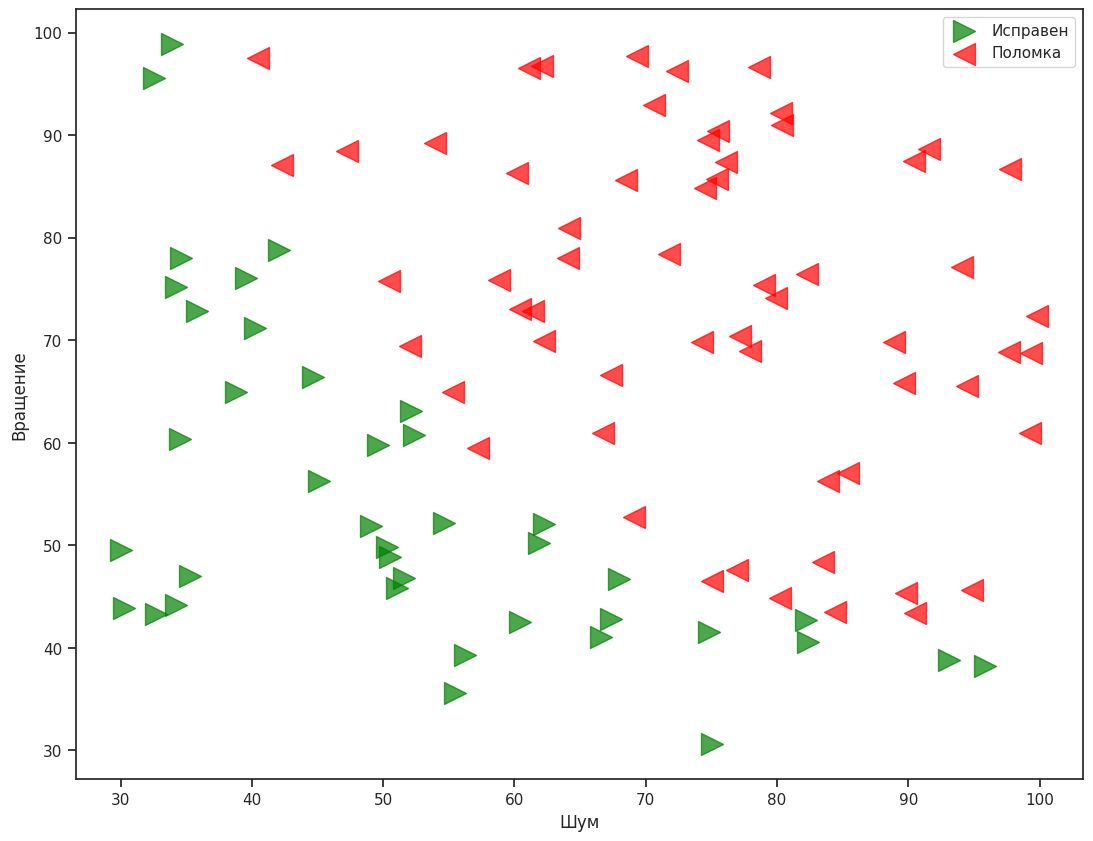

In [486]:
#строим набор наших данных
plt.figure(figsize=(13,10))
plotData (df['noise'][df['class'] == 0], df['rotation'][df['class'] == 0], 250, '>', 'green', 'Исправен' )
plotData (df['noise'][df['class'] == 1], df['rotation'][df['class'] == 1], 250, '<', 'red', 'Поломка')
plt.show()

## Задание 2: Вычисление функции стоимости и градиентов
#### В этой части задания, определяются функция стоимости и градиенты для задачи логистической регрессии.

In [487]:
[m, n] = X.shape

In [488]:
initial_theta = np.zeros((n , 1))

До того, как приступать к написанию функции стоимости, определим гипотезу логистической
регрессии:
$$
\begin{aligned}
h_θ(x) &= g(θ^Tx)
\end{aligned}
$$
где сигмоидная функция g, определяется как:
$$
\begin{aligned}
g(z) &= \frac{1}{1+e^-z}\
\end{aligned}
$$


Сначала следует описать эту функцию в функции sigmoid. Для проверки попробуйте вычислить несколько значений сигмоидной функции, написав sigmoid(x). Для больших положительных значений x, значение сигмоидной функции должно быть близко к 1, а для высоких отрицательных – к 0. Значение функции sigmoid в нуле должно быть равно 0,5. Программа должна работать также с векторами и матрицами. Для работы с матрицами сигмоидная функция должна обрабатывать каждый элемент матрицы по отдельности.

In [489]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [490]:
def costFunction(theta, X, y, return_grad=False):
  m = len(y)  # количество примеров
  h = sigmoid(X @ theta)  # гипотеза

  # Стоимость
  J = (-1 / m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))

  # Градиент
  if return_grad:
      grad = (1 / m) * (X.T @ (h - y))
      return J, grad
  else:
      return J

In [491]:
cost, grad = costFunction(initial_theta, X, y, True)

In [492]:
print('Значение функции стоимости при начальных (нулевых) значениях вектора thetа:', cost, '\n');
print('Значение градиента при начальных (нулевых) значениях вектора thetа:',grad, ' \n');

Значение функции стоимости при начальных (нулевых) значениях вектора thetа: [[0.69314718]] 

Значение градиента при начальных (нулевых) значениях вектора thetа: [[ -0.1       ]
 [-11.26284221]
 [-12.00921659]]  



## Задание 3: Оптимизация

  В этом задании предполагается вместо уже известного метода градиентного спуска использовать для вычисления оптимальных значений параметров theta библиотеку scipy


In [493]:
from scipy.optimize import fmin
myargs=(X, y)
theta = fmin(costFunction, x0=initial_theta, args=myargs)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [494]:
costFunction(theta, X, y)

array([0.2034977])

In [495]:
print('Значение theta:',theta)

Значение theta: [-25.16130062   0.20147143   0.20623142]


### Отображение границы классов


In [496]:
def plotDecisionBoundary(X, theta, df):
  """
  Указание: Ваша задача разобраться, как строиться граница классов
  """
  x_values = [np.min(X[:, 1]), np.max(X[:, 2])]
  y_values = - (theta[0] + np.dot(theta[1], x_values)) / theta[2]

  plt.figure(figsize=(13,10))
  plt.plot(x_values, y_values, linewidth = 3, color = 'black', label='Граница классов')
  plotData(df['noise'][df['class'] == 0], df['rotation'][df['class'] == 0], 250, '>', 'green', 'Исправен' )
  plotData(df['noise'][df['class'] == 1], df['rotation'][df['class'] == 1], 250, '<', 'red', 'Поломка')

  plt.show()

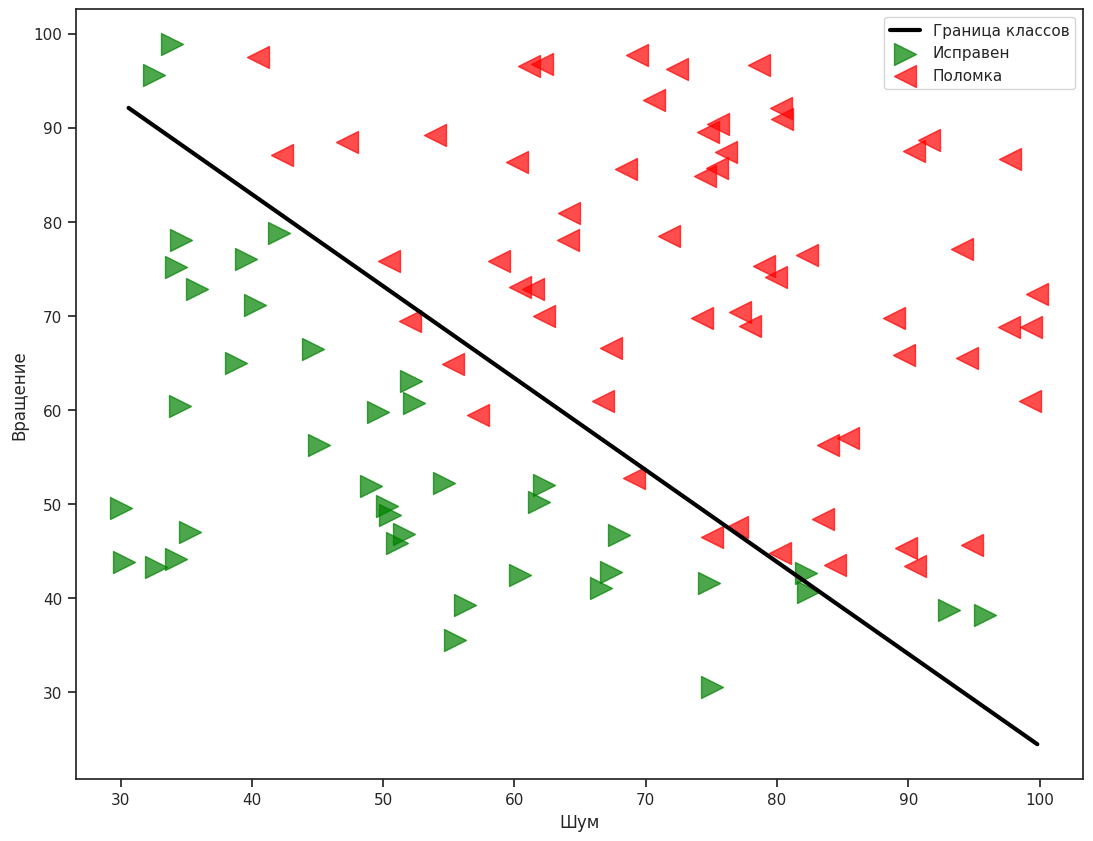

In [497]:
plotDecisionBoundary(X, theta, df)

## Задание 4: Предсказание и оценка точности

  После выполнения обучения следует обеспечить предсказание для тех
  данных, которые не были использованы в процессе обучения, т.е. данных,
  которые возникают в процессе эксплуатации автомобиля.
  В этом задании, логистическая регрессия используется для предсказания
  вероятности того, что двигатель, состояние которого характеризуется
  следующими параметрами, шум - 45 ед., вибрация - 85 ед, является
  исправным.

  Более того, Вам предстоит вычислить точность (погрешность)
  используемой логистической модели.

  Задача состоит в завершении кода predict.m

  Определение вероятности работоспособности или отказа двигателя,
  состояние которого характеризуется следующими параметрами, шум - 45 ед.,
  вибрация - 85 ед.

In [498]:
prob = sigmoid(np.array([1, 45, 85]).dot(theta[:, np.newaxis]))

In [499]:
print('Для двигателя с уровнем шума 45 и вибрацией 85, предсказывается поломка с вероятностью:  {:.2%} \n'.format(prob[0]))

Для двигателя с уровнем шума 45 и вибрацией 85, предсказывается поломка с вероятностью:  80.76% 



In [500]:
def predict(x, y, threshold=0.5):
  """
  PREDICT Отнесение образца к классам 0 или 1 ("исправен" или "не исправен")
  в процессе линейной регрессии на основании оценки theta
  PREDICT обеспечивает классификацию X с пороговым
  значением 0.5 (т.е., если значение сигмоидной функции
  sigmoid(theta'*x) >= 0.5, то присвоение 1)
  """
  probs = sigmoid(X @ theta)

  # Применяем пороговое значение для классификации
  predictions = (probs >= threshold).astype(int)

  # Вычисляем точность как долю правильных предсказаний
  accuracy = np.mean(predictions == y) * 100  # точность в процентах

  return accuracy

In [501]:
print('Точность обучения: {:.0%} \n'.format(predict(X, y)/100))

Точность обучения: 52% 



## Задание 5: Регуляризованная логистическая регрессия

Исследуемые данные не являются линейно сепарабельными и, следовательно, не могут быть разделены на положительный и отрицательный классы прямой линией. Поэтому буквальное применение метода простой  логистической регрессии не подходит в данном примере, поскольку он подразумевает прямолинейную границу раздела двух областей. Тем не менее, использование логистической регрессии возможно, а именно, посредством применения полиноминальных признаков, подобно полиноминальной регрессии.

## Инициализация

In [502]:
data = pd.read_csv('test.csv')

In [503]:
data.head()

,test_1,test_2,class
0,-0.092742,0.68494,1
1,-0.213710,0.69225,1
2,-0.375000,0.50219,1
3,-0.513250,0.46564,1
4,-0.524770,0.20980,1


In [504]:
data.describe()

,test_1,test_2,class
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646563,1.000000
max,1.070900,1.108900,1.000000


In [505]:
m = len(data)
x = np.array(data['test_1'])
temp = np.array(data['test_2'])
y = np.array(data['class'])

x = x.reshape((m, 1))
temp = temp.reshape((m, 1))
y = y.reshape((m, 1))
X = np.hstack((temp,x))
print(X[0:5])

[[ 0.68494  -0.092742]
 [ 0.69225  -0.21371 ]
 [ 0.50219  -0.375   ]
 [ 0.46564  -0.51325 ]
 [ 0.2098   -0.52477 ]]


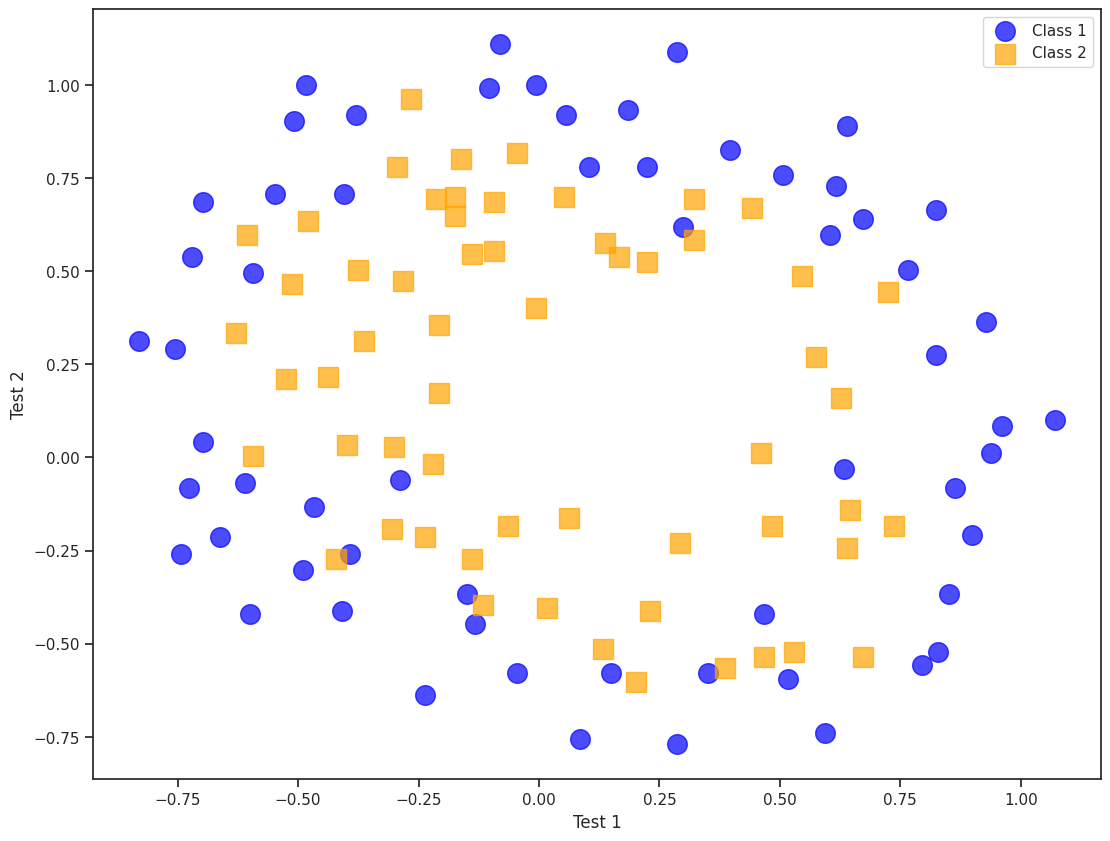

In [506]:
plt.figure(figsize=(13,10))
plotData(data['test_1'][data['class'] == 0], data['test_2'][data['class'] == 0], 200, 'o', 'blue', 'Class 1' )
plotData(data['test_1'][data['class'] == 1], data['test_2'][data['class'] == 1], 200, 's', 'orange', 'Class 2')
plt.xlabel('Test 1')
plt.ylabel('Test 2')
plt.show()

In [507]:
def mapFeature(X1, X2):
    degree = 6
    out = np.ones(( X1.shape[0], sum(range(degree + 2)) ))
    curr_column = 1
    for i in range(1, degree + 1):
        for j in range(i+1):
            out[:,curr_column] = np.power(X1,i-j) * np.power(X2,j)
            curr_column += 1
    return out

In [508]:
X = mapFeature(X[:,0], X[:,1])

In [509]:
X.shape

(118, 28)

In [510]:
initial_theta = np.zeros((X.shape[1], 1))
initial_theta

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

Вычисление и отображение начальных значений функции стоимости и
градиента для регуляризованной логистической регрессии

In [511]:
def costFunctionReg(theta, X, y, lambda_reg):
  """
  Вычисление функции стоимости и значения градиента(ов) для
  задачи логистической регрессии с регуляризацией.
  costFunctionReg(theta, X, y, lambda_reg) вычисляет функцию стоимости, используя
  theta в качестве параметра логистической регрессии, а также значение(я)
  градиентов.
  """
  m = len(y)  # количество примеров
  h = sigmoid(X @ theta)
  J = (-1 / m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h)) + (lambda_reg / (2 * m)) * np.sum(theta[1:] ** 2)

  return J

In [512]:
cost = costFunctionReg(initial_theta, X, y, 1)

In [513]:
print('Значение функции стоимости при начальном значении theta (zeros):\n', cost)

Значение функции стоимости при начальном значении theta (zeros):
 [[0.69314718]]


In [514]:
def gradFunctionReg(theta, X, y, lambda_reg):
    grad = np.zeros(theta.shape)
    grad = (1./m) * np.dot(sigmoid( np.dot(X,theta) ).T - y, X).T + ( float(lambda_reg) / m )*theta

    return  grad.flatten()

In [515]:
gradFunctionReg(initial_theta, X, y, 1)

array([-0.5       , -0.5       , -0.5       , ...,  0.03918559,
        0.03918559, -0.03918559])

## Задание 6: Регуляризация и точность

Дополнительное задание:
В этом задании, варьируя значения lambda, выяснить влияние регуляризации на поведение
границы разделения классов

Указание: Продемонстрировать эффект для lambda (0, 1, 10, 100).

In [516]:
def plotDecisionBoundary(theta, lambda_reg):
    plt.figure(figsize=(10,10))

    plotData(data['test_1'][data['class'] == 0], data['test_2'][data['class'] == 0], 200, 'o', 'blue', 'Class 1' )
    plotData(data['test_1'][data['class'] == 1], data['test_2'][data['class'] == 1], 200, 's', 'orange', 'Class 2')


    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    uu, vv = np.meshgrid(u, v)
    z = np.zeros(( len(u), len(v) ))


    for i in range(len(u)):
        for j in range(len(v)):
            z[i,j] = np.dot(mapFeature(np.array([u[i]]), np.array([v[j]])),theta)
    z = np.transpose(z)

    plt.contour(u, v, z, levels=[0], colors='black', linewidths=3)
    plt.title('\n lambda = {:d}, Точность обучения: {:.2%} \n'.format(lambda_reg, predict(X, y)/100), fontsize=20)

    plt.xlabel('Test 1', fontsize=20)
    plt.ylabel('Test 2', fontsize=20)
    plt.yticks(size = 15)
    plt.xticks(size = 15)
    plt.yticks(size = 15)
    plt.xticks(size = 15)
    plt.legend(fontsize=15)
    plt.show()


Optimization terminated successfully.
         Current function value: 0.224562
         Iterations: 678
         Function evaluations: 20271
         Gradient evaluations: 699


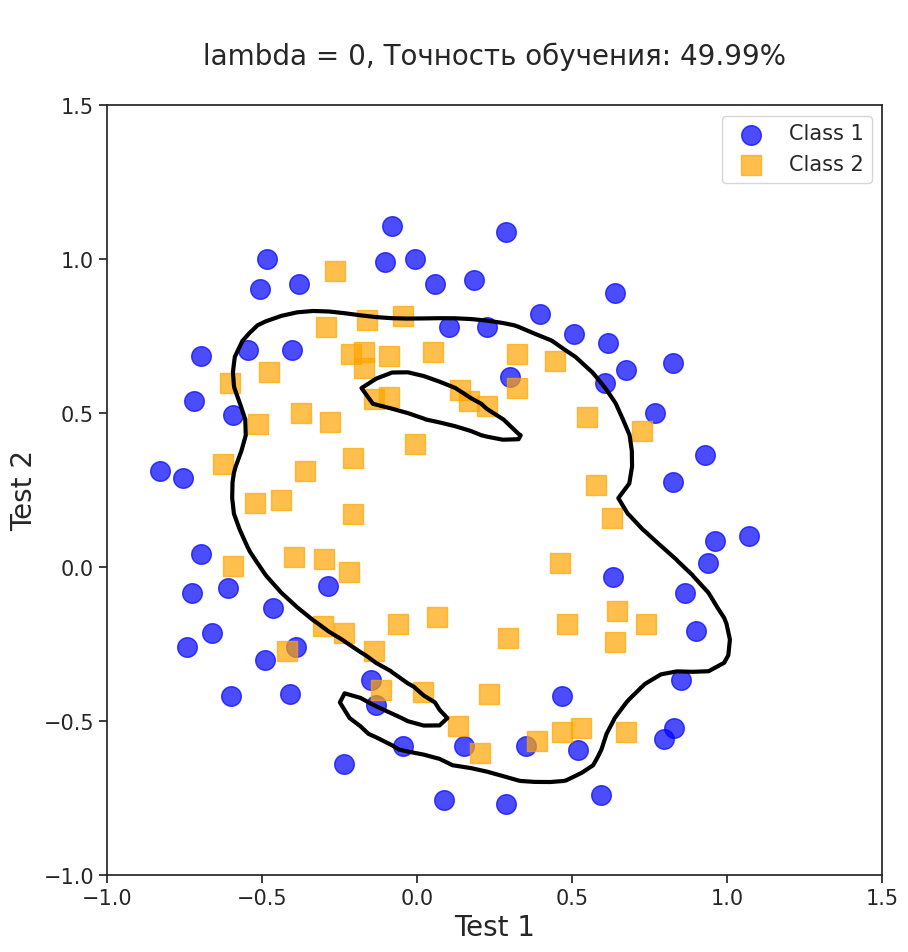

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 1392
         Gradient evaluations: 48


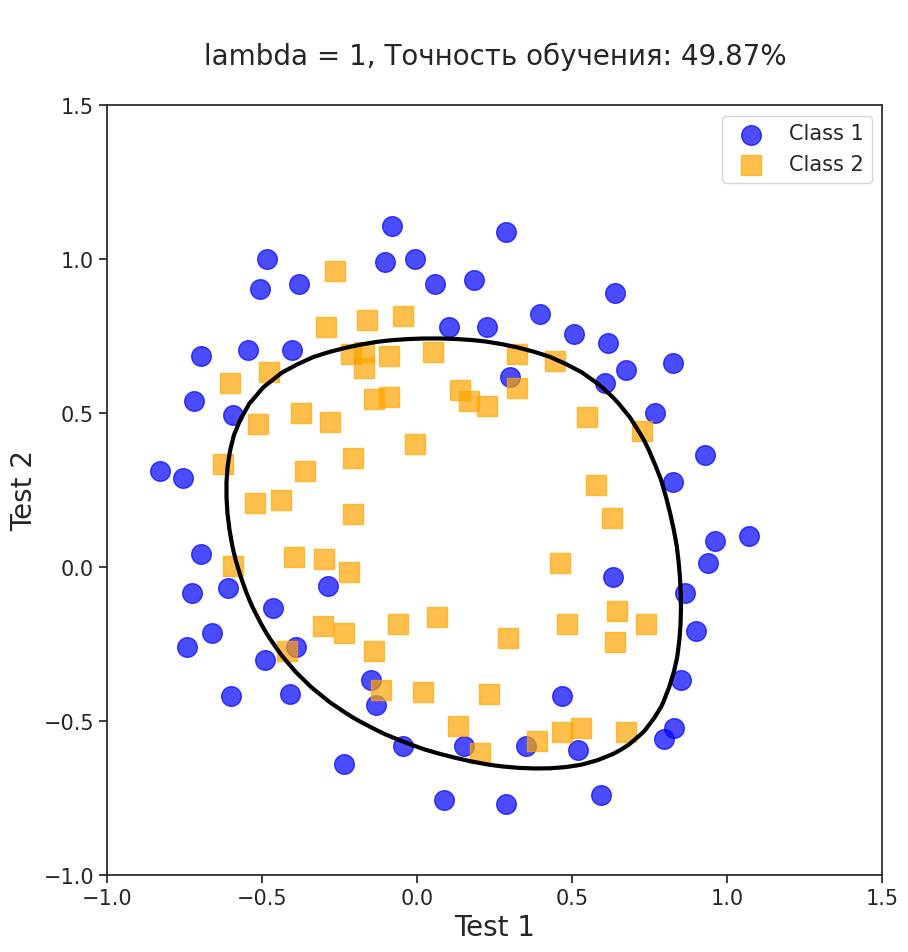

Optimization terminated successfully.
         Current function value: 0.648216
         Iterations: 21
         Function evaluations: 638
         Gradient evaluations: 22


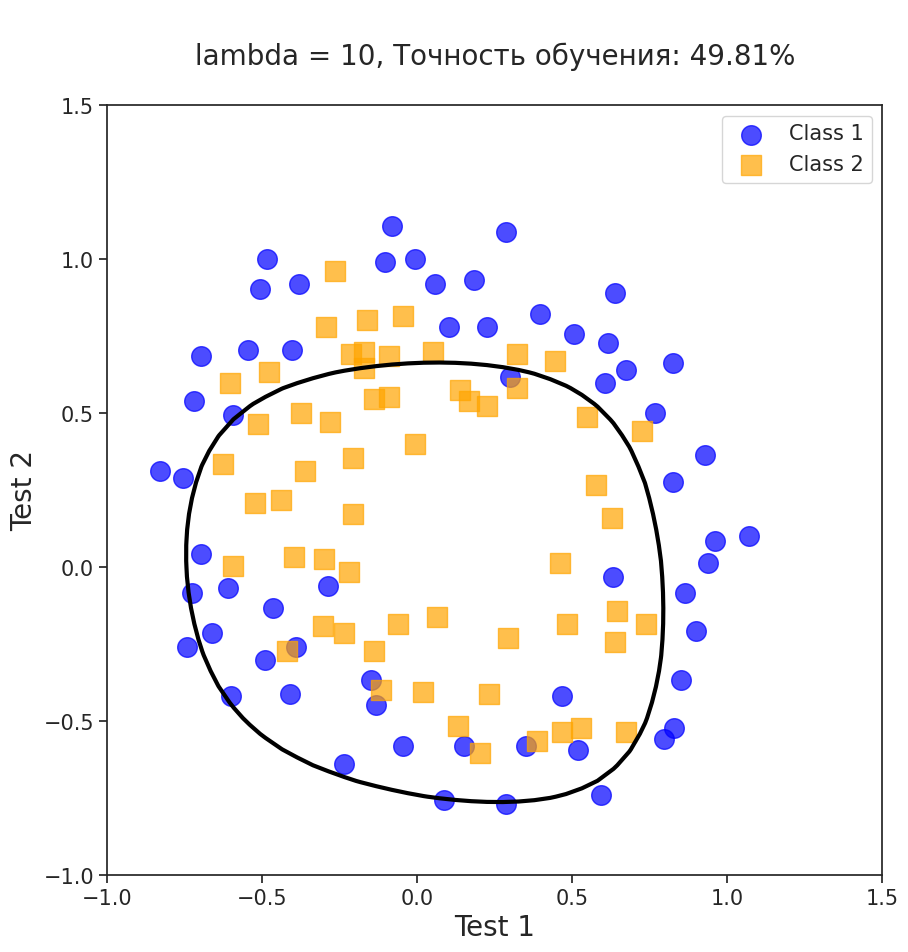

Optimization terminated successfully.
         Current function value: 0.686484
         Iterations: 7
         Function evaluations: 232
         Gradient evaluations: 8


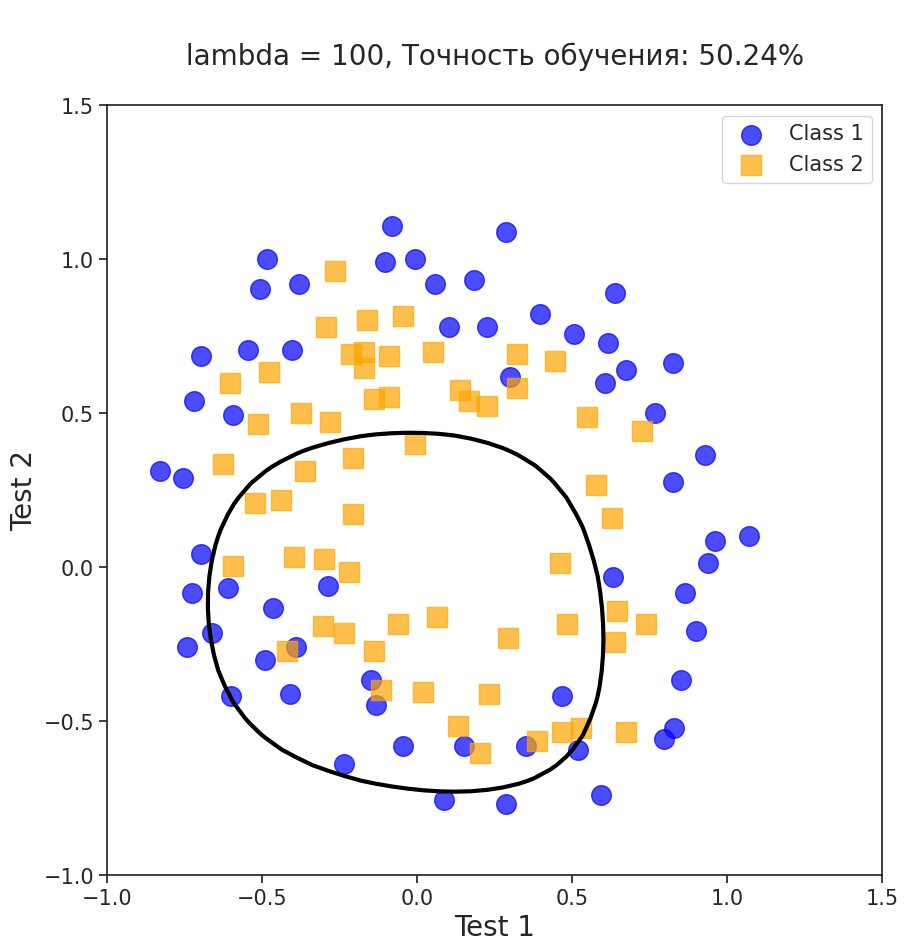

Optimization terminated successfully.
         Current function value: 0.688561
         Iterations: 7
         Function evaluations: 232
         Gradient evaluations: 8


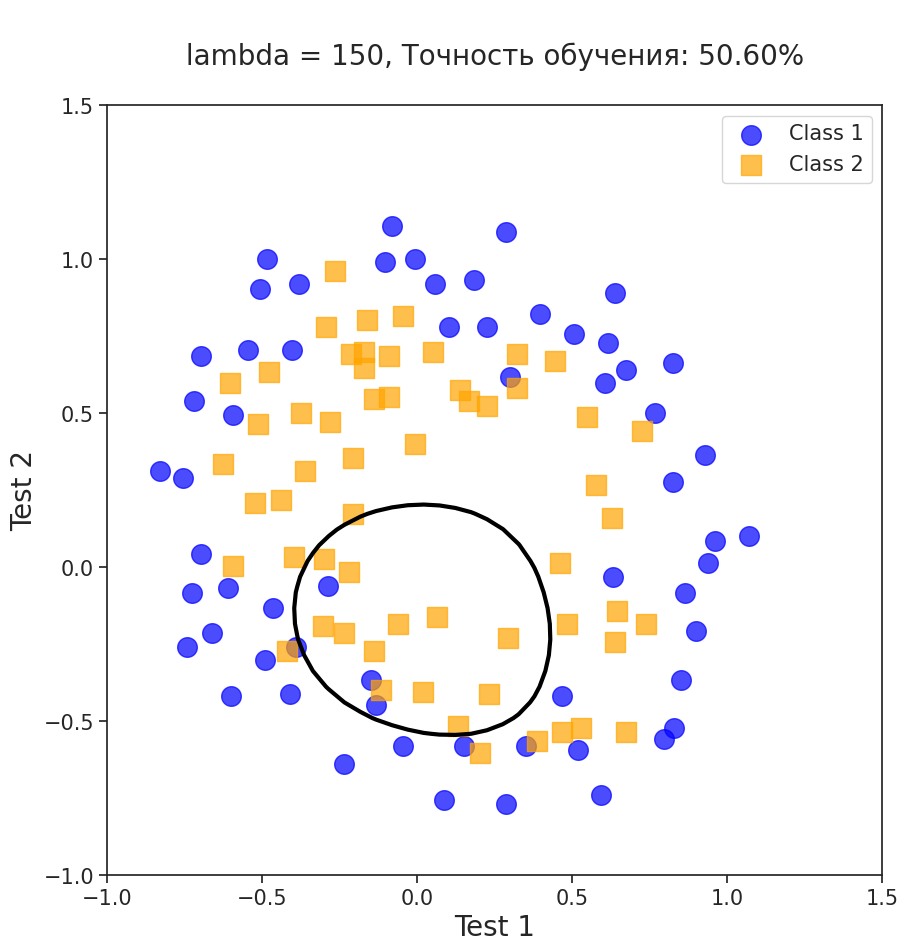

In [517]:
from scipy.optimize import fmin_bfgs
lambda_reg = [0, 1, 10, 100, 150]

for lambda_i in lambda_reg:
    myargs=(X, y, lambda_i)
    theta = fmin_bfgs(costFunctionReg, x0 = initial_theta, args = myargs)
    plotDecisionBoundary(theta, lambda_i)

In [518]:
lambda_reg = 0
myargs=(X, y, lambda_reg)
theta = fmin_bfgs(costFunctionReg, x0 = initial_theta, args = myargs)

Optimization terminated successfully.
         Current function value: 0.224562
         Iterations: 678
         Function evaluations: 20271
         Gradient evaluations: 699


In [519]:
print('Максимальная точность обучения: {:.2%} \n'.format(predict(X, y)/100))

Максимальная точность обучения: 49.99% 

